In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# set the display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# read the csv file
data = pd.read_csv('Students.csv', encoding='latin-1')

In [4]:
# data shape
print(f"Data shape: {data.shape}")

Data shape: (3614, 16)


In [5]:
# Drop identifying columns while keeping identical response patterns
# Note: We keep rows with identical responses because they represent different students
# with the same usage patterns, which is valuable data for modeling
data_clean = data.drop(columns=['State', 'Student_Name'])

# Use Cases

C:\Users\jcheng\AppData\Local\Temp\ipykernel_34992\3090572763.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_use_cases.values, y=top_use_cases.index, palette='viridis')


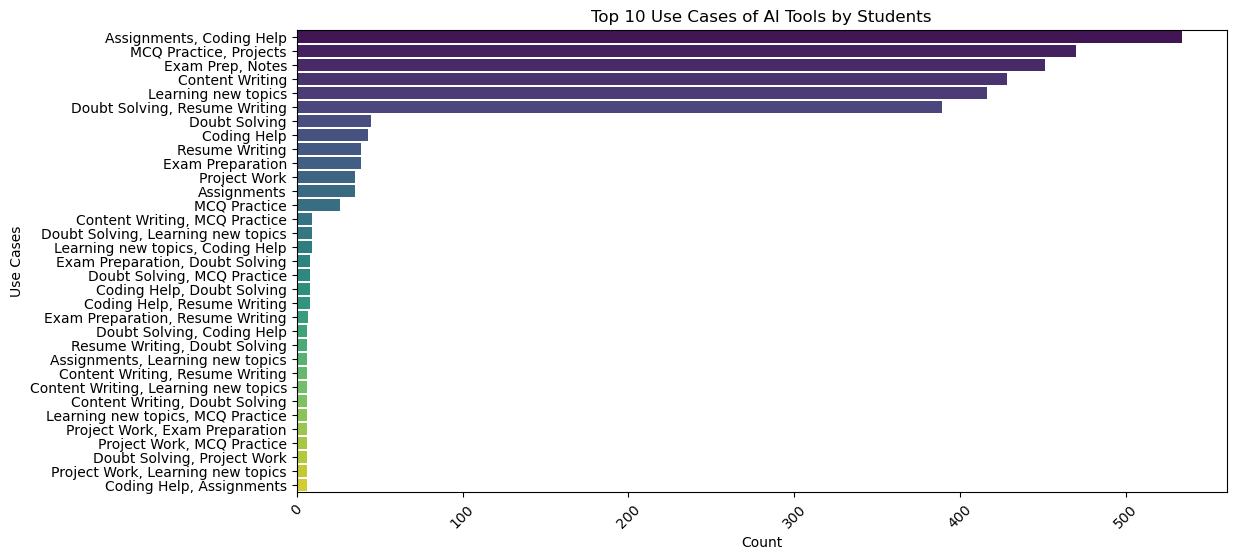

In [6]:
# plot of top 10 different use cases
plt.figure(figsize=(12, 6))
top_use_cases = data_clean['Use_Cases'].value_counts().head(33)
sns.barplot(x=top_use_cases.values, y=top_use_cases.index, palette='viridis')
plt.title('Top 10 Use Cases of AI Tools by Students')
plt.xlabel('Count')
plt.ylabel('Use Cases')
plt.xticks(rotation=45)
plt.show()

There are multiple use cases for students. And some use cases quite close to each other.

In [7]:
# create a new column for Use_Cases split by a comma 
data_clean['Use_Cases_Split'] = data_clean['Use_Cases'].str.split(',')

In [8]:
import re
from collections import Counter

# First, let's extract all individual use cases from the split data
def extract_all_individual_use_cases(df, column='Use_Cases_Split'):
    """
    Extract all individual use cases from the split column
    """
    all_individual_cases = []
    for case_list in df[column].dropna():
        for case in case_list:
            if case.strip():  # Only add non-empty cases
                all_individual_cases.append(case.strip().lower())
    return all_individual_cases

# Get all individual use cases
all_cases = extract_all_individual_use_cases(data_clean)
case_counts = Counter(all_cases)

print("All individual use cases and their frequencies:")
for case, count in case_counts.most_common():
    print(f"'{case}': {count}")

All individual use cases and their frequencies:
'coding help': 766
'assignments': 749
'mcq practice': 692
'doubt solving': 638
'resume writing': 617
'content writing': 602
'learning new topics': 594
'projects': 470
'exam prep': 451
'notes': 451
'project work': 229
'exam preparation': 202


In [9]:
# Create a comprehensive mapping for standardizing individual use cases
def create_use_case_mapping():
    """
    Create a mapping dictionary to standardize similar use cases
    """
    mapping = {
        # Exam related
        'exam prep': 'exam preparation',
        'exam preparation': 'exam preparation',
        
        # Project related
        'projects': 'project work',
        'project work': 'project work',
        'project': 'project work'
    }
    
    return mapping

# Apply the mapping to standardize individual use cases
use_case_mapping = create_use_case_mapping()

In [10]:
def standardize_individual_use_cases(df):
    """
    Standardize individual use cases using the mapping
    """
    def apply_mapping_to_list(case_list):
        # Handle None/NaN cases
        if case_list is None or (isinstance(case_list, float) and pd.isna(case_list)):
            return case_list
        
        # Handle empty list
        if not isinstance(case_list, list) or len(case_list) == 0:
            return case_list
        
        standardized_cases = []
        for case in case_list:
            if case and isinstance(case, str):  # Check if case is not None and is string
                # Clean and normalize the case
                cleaned_case = case.strip().lower()
                # Apply mapping
                standardized_case = use_case_mapping.get(cleaned_case, cleaned_case)
                # Avoid duplicates
                if standardized_case not in standardized_cases:
                    standardized_cases.append(standardized_case)
        
        return standardized_cases
    
    return df['Use_Cases_Split'].apply(apply_mapping_to_list)

# Apply standardization
data_clean['Use_Cases_Split_Standardized'] = standardize_individual_use_cases(data_clean)

# Convert back to string format for easier viewing
data_clean['Use_Cases_Standardized'] = data_clean['Use_Cases_Split_Standardized'].apply(
    lambda x: ', '.join([case.title() for case in x]) if x and isinstance(x, list) else ''
)

In [11]:
# Create binary features for each use case
def create_binary_use_case_features(df):
    """
    Create binary columns for each unique use case
    """
    # Get all unique use cases from standardized data
    all_use_cases = ['coding help', 'assignments', 'project work', 'mcq practice', 
                     'exam preparation', 'doubt solving', 'resume writing', 
                     'content writing', 'learning new topics', 'notes']
    
    # Create binary columns
    for use_case in all_use_cases:
        col_name = f'uses_{use_case.replace(" ", "_")}'
        df[col_name] = df['Use_Cases_Split_Standardized'].apply(
            lambda x: 1 if x and use_case in x else 0
        )
    
    return df

# Apply the function
data_clean = create_binary_use_case_features(data_clean)

# Show the new binary features
binary_features = [col for col in data_clean.columns if col.startswith('uses_')]
print("Binary use case features:")
for feature in binary_features:
    print(f"{feature}: {data_clean[feature].sum()} students")

Binary use case features:
uses_coding_help: 766 students
uses_assignments: 749 students
uses_project_work: 699 students
uses_mcq_practice: 692 students
uses_exam_preparation: 653 students
uses_doubt_solving: 638 students
uses_resume_writing: 617 students
uses_content_writing: 602 students
uses_learning_new_topics: 594 students
uses_notes: 451 students


In [12]:
# top 5
# data_clean.head()

# AI_Tools_Used

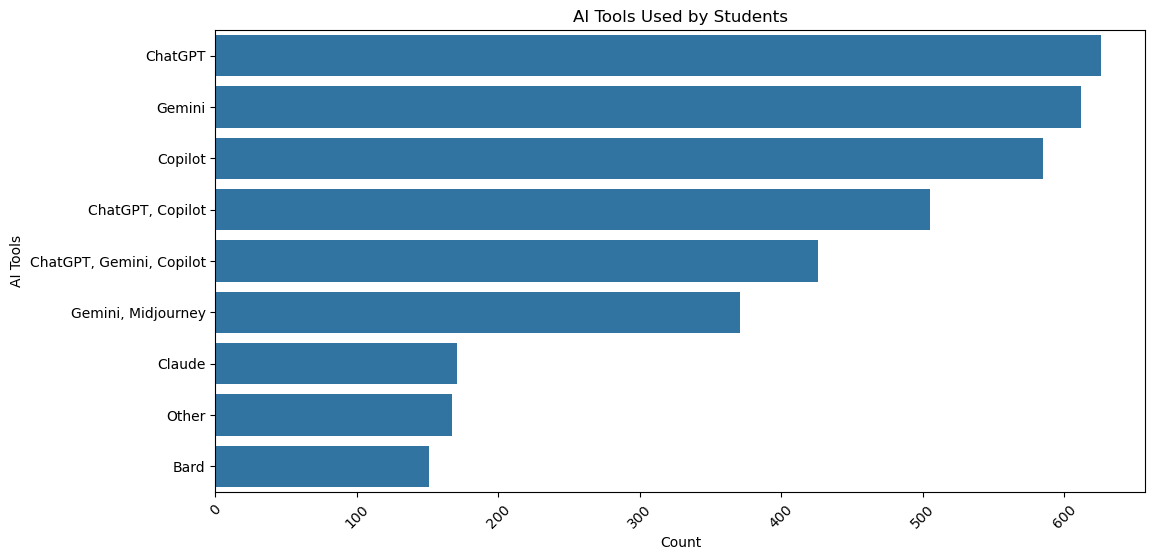

In [13]:
# plot AI_Tools_Used 
plt.figure(figsize=(12, 6))
sns.countplot(y='AI_Tools_Used', data=data_clean, order=data_clean['AI_Tools_Used'].value_counts().index)
plt.title('AI Tools Used by Students')
plt.xlabel('Count')
plt.ylabel('AI Tools')
plt.xticks(rotation=45)
plt.show()

There are mixed AI tools used by one student.

In [14]:
def create_ai_tools_dummy_variables(df, column_name='AI_Tools_Used'):
    """
    Create dummy variables for comma-separated AI tools column
    """
    print("=== CREATING DUMMY VARIABLES FOR AI TOOLS ===")
    
    # Method 1: Using pandas get_dummies with separator
    print("Method 1: Using pandas get_dummies")
    
    # Create dummy variables directly from comma-separated values
    # Convert to int to get 1/0 instead of True/False
    dummies = df[column_name].str.get_dummies(sep=', ').astype(int)
    
    # Add prefix to column names for clarity
    dummies.columns = [f'ai_tool_{col.lower().replace(" ", "_")}' for col in dummies.columns]
    
    print(f"Created {len(dummies.columns)} dummy variables:")
    for col in dummies.columns:
        print(f"  • {col}: {dummies[col].sum()} students use this tool")
    
    # Show the dummy variables
    print(f"\nDummy variables shape: {dummies.shape}")
    print(f"Sample of dummy variables:")
    print(dummies.head())
    
    # Verify data types
    print(f"\nData types:")
    print(f"All columns are integers: {all(dummies[col].dtype in ['int64', 'int32'] for col in dummies.columns)}")
    
    return dummies

# Apply the AI Tools dummy variables function to data_clean
ai_tools_dummies_clean = create_ai_tools_dummy_variables(data_clean, 'AI_Tools_Used') 
# Apply to your data
data_clean_v1 = pd.concat([data_clean, ai_tools_dummies_clean], axis=1)

=== CREATING DUMMY VARIABLES FOR AI TOOLS ===
Method 1: Using pandas get_dummies
Created 7 dummy variables:
  • ai_tool_bard: 151 students use this tool
  • ai_tool_chatgpt: 1557 students use this tool
  • ai_tool_claude: 171 students use this tool
  • ai_tool_copilot: 1516 students use this tool
  • ai_tool_gemini: 1409 students use this tool
  • ai_tool_midjourney: 371 students use this tool
  • ai_tool_other: 167 students use this tool

Dummy variables shape: (3614, 7)
Sample of dummy variables:
   ai_tool_bard  ai_tool_chatgpt  ai_tool_claude  ai_tool_copilot  \
0             0                0               0                0   
1             0                1               0                0   
2             0                0               0                1   
3             0                0               0                1   
4             0                0               0                0   

   ai_tool_gemini  ai_tool_midjourney  ai_tool_other  
0               1         

In [15]:
# top 5 of data clean v1
# data_clean_v1.head(5)

## Drop Necessary Columns

In [16]:
# column names of data clean 
data_clean_v1.columns

Index(['College_Name', 'Stream', 'Year_of_Study', 'AI_Tools_Used',
       'Daily_Usage_Hours', 'Use_Cases', 'Trust_in_AI_Tools',
       'Impact_on_Grades', 'Do_Professors_Allow_Use', 'Preferred_AI_Tool',
       'Awareness_Level', 'Willing_to_Pay_for_Access', 'Device_Used',
       'Internet_Access', 'Use_Cases_Split', 'Use_Cases_Split_Standardized',
       'Use_Cases_Standardized', 'uses_coding_help', 'uses_assignments',
       'uses_project_work', 'uses_mcq_practice', 'uses_exam_preparation',
       'uses_doubt_solving', 'uses_resume_writing', 'uses_content_writing',
       'uses_learning_new_topics', 'uses_notes', 'ai_tool_bard',
       'ai_tool_chatgpt', 'ai_tool_claude', 'ai_tool_copilot',
       'ai_tool_gemini', 'ai_tool_midjourney', 'ai_tool_other'],
      dtype='object')

In [17]:
# remove 'Student_Name', 'College_Name', 'Use_Cases', 'State', 'Use_Cases_Advanced', 'Use_Cases_Split','Use_Cases_Length', 'Use_Cases_Split_Standardized'
data_cleaned_final = data_clean_v1.drop(columns=['College_Name', 'Stream', 'AI_Tools_Used', 'Use_Cases', 'Use_Cases_Split', 'Use_Cases_Split_Standardized', 'Use_Cases_Standardized'])

In [18]:
# top 5 of data cleaned final
# data_cleaned_final.head(5)

# One Hot Encoding

In [19]:
def apply_appropriate_encoding(df):
    """
    Apply the correct encoding strategy for each categorical column
    """
    # Make a copy to avoid modifying original
    df = df.copy()
    
    # 1. ONE-HOT ENCODING for nominal categories
    nominal_columns = ['AI_Tools_Used', 'Preferred_AI_Tool', 'Device_Used', 'Internet_Access']
    
    for col in nominal_columns:
        if col in df.columns:
            # Create dummy variables with dtype=int to get 1/0 instead of True/False
            dummies = pd.get_dummies(df[col], prefix=col.lower(), drop_first=False, dtype=int)
            df = pd.concat([df, dummies], axis=1)
            print(f"One-hot encoded {col}: {len(dummies.columns)} features created")
    
    # 2. BINARY ENCODING for yes/no columns only
    binary_mappings = {
        'Do_Professors_Allow_Use': {'No': 0, 'Yes': 1},
        'Willing_to_Pay_for_Access': {'No': 0, 'Yes': 1}
    }
    
    for col, mapping in binary_mappings.items():
        if col in df.columns:
            df[f'{col}_encoded'] = df[col].map(mapping)
            print(f"Binary encoded {col}: 0/1")
    
    # 3. Skip Trust_in_AI_Tools and Impact_on_Grades if they're already numerical
    print(f"\nSkipping Trust_in_AI_Tools and Impact_on_Grades - already numerical")
    print(f"Trust_in_AI_Tools type: {df['Trust_in_AI_Tools'].dtype}")
    print(f"Impact_on_Grades type: {df['Impact_on_Grades'].dtype}")
    
    return df

# Apply encoding strategy
data_encoded = apply_appropriate_encoding(data_cleaned_final)

# Show the results
print("\nNew encoded columns created:")
encoded_cols = [col for col in data_encoded.columns if any(x in col for x in ['_encoded', 'stream_', 'ai_tools_used_', 'preferred_ai_tool_', 'device_used_', 'internet_access_'])]
print(encoded_cols)

# Display sample of encoded data
print("\nSample of encoded data:")
print(data_encoded[['Trust_in_AI_Tools', 'Impact_on_Grades'] + encoded_cols[:5]].head())

# Verify data types of encoded columns
print("\nData types of encoded columns:")
for col in encoded_cols[:5]:
    if col in data_encoded.columns:
        print(f"{col}: {data_encoded[col].dtype} | Unique values: {sorted(data_encoded[col].unique())}")

One-hot encoded Preferred_AI_Tool: 6 features created
One-hot encoded Device_Used: 3 features created
One-hot encoded Internet_Access: 3 features created
Binary encoded Do_Professors_Allow_Use: 0/1
Binary encoded Willing_to_Pay_for_Access: 0/1

Skipping Trust_in_AI_Tools and Impact_on_Grades - already numerical
Trust_in_AI_Tools type: int64
Impact_on_Grades type: int64

New encoded columns created:
['preferred_ai_tool_Bard', 'preferred_ai_tool_ChatGPT', 'preferred_ai_tool_Claude', 'preferred_ai_tool_Copilot', 'preferred_ai_tool_Gemini', 'preferred_ai_tool_Other', 'device_used_Laptop', 'device_used_Mobile', 'device_used_Tablet', 'internet_access_High', 'internet_access_Medium', 'internet_access_Poor', 'Do_Professors_Allow_Use_encoded', 'Willing_to_Pay_for_Access_encoded']

Sample of encoded data:
   Trust_in_AI_Tools  Impact_on_Grades  preferred_ai_tool_Bard  \
0                  2                 2                       0   
1                  3                -3                       

## Drop Unnecessary Columns

In [20]:
# Drop unnecessary columns
data_encoded_clean = data_encoded.drop(columns=[
    'Do_Professors_Allow_Use', 'Preferred_AI_Tool',
    'Willing_to_Pay_for_Access', 'Device_Used',
       'Internet_Access'
])

In [21]:
# data shape of encoded clean data
print(f"\nFinal data shape after encoding: {data_encoded_clean.shape}")


Final data shape after encoding: (3614, 36)


In [22]:
# save it as a csv file
data_encoded_clean.to_csv('Students_Cleaned_Encoded_v1.csv', index=False)

In [23]:
# top 5
data_encoded_clean.head(5)

,Year_of_Study,Daily_Usage_Hours,Trust_in_AI_Tools,Impact_on_Grades,Awareness_Level,uses_coding_help,uses_assignments,uses_project_work,uses_mcq_practice,uses_exam_preparation,uses_doubt_solving,uses_resume_writing,uses_content_writing,uses_learning_new_topics,uses_notes,ai_tool_bard,ai_tool_chatgpt,ai_tool_claude,ai_tool_copilot,ai_tool_gemini,ai_tool_midjourney,ai_tool_other,preferred_ai_tool_Bard,preferred_ai_tool_ChatGPT,preferred_ai_tool_Claude,preferred_ai_tool_Copilot,preferred_ai_tool_Gemini,preferred_ai_tool_Other,device_used_Laptop,device_used_Mobile,device_used_Tablet,internet_access_High,internet_access_Medium,internet_access_Poor,Do_Professors_Allow_Use_encoded,Willing_to_Pay_for_Access_encoded
0,4,0.9,2,2,9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1
1,2,3.4,3,-3,6,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0
2,2,3.6,5,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0
3,2,2.9,5,2,5,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0
4,1,0.9,1,3,8,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,1
